In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "MazeF4-v0"

NUMBER_OF_EXPLORE_TRIALS = 2000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.025
EPSILON = 0.3

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.00

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■
■ □ □ □ □ $ ■
■ □ ■ ■ ■ ■ ■
■ □ A □ □ ■ ■
■ □ ■ ■ ■ ■ ■
■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 1min 6s, sys: 526 ms, total: 1min 7s
Wall time: 1min 10s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

##9##### 2 None ##1#####         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 1709 tga: 51    talp: 22091 tav: 8.32   num: 1


#####0#0 2 None #####1#1         (empty)               q: 1.0   r: 457.7  ir: 0.0    f: 457.7  exp: 334 tga: 97    talp: 22038 tav: 1.55e+02 num: 1


#010#### 4 None #101####         (empty)               q: 0.923 r: 398.3  ir: 0.0    f: 367.6  exp: 50  tga: 161   talp: 22046 tav: 4.25e+02 num: 1


0###0111 2 None 1###1000         (#010####)            q: 0.794 r: 774.0  ir: 0.0    f: 614.4  exp: 391 tga: 162   talp: 22063 tav: 37.2   num: 1


1#0#1101 2 None ##1#####         (#1#1####)            q: 0.472 r: 785.7  ir: 0.0    f: 371.0  exp: 3324 tga: 164   talp: 22039 tav: 1.46e+02 num: 1


##0##10# 2 None ##1#####         (11#11##1)            q: 0.367 r: 785.7  ir: 0.0    f: 288.1  exp: 3325 tga: 164   talp: 22039 tav: 1.46e+02 num: 1


##1###0# 6 None ##0#####         (empty)               q: 1.0   r: 409.1  ir: 0.0    f: 409.1  exp: 3

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population()
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 3.57 s, sys: 39.4 ms, total: 3.61 s
Wall time: 3.73 s


In [7]:
print(metrics_exploit[-1])

{'trial': 499, 'steps_in_trial': 1, 'reward': 1000, 'knowledge': 80.0, 'population': 95, 'numerosity': 95, 'reliable': 29}


### Performance

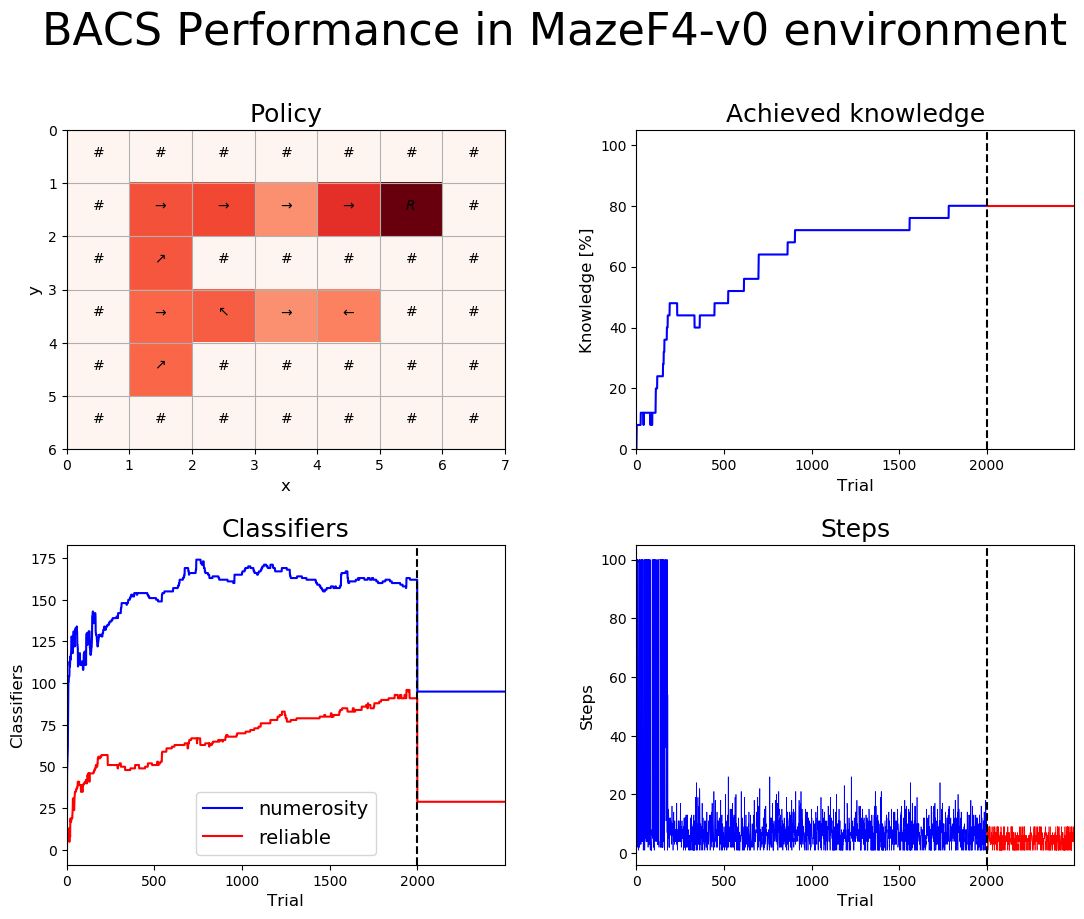

In [8]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [9]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS
avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")
print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  11.046  for a total of  2000  trials in EXPLORATION
Average number of steps to solve the maze is  4.54  for a total of  500  trials in EXPLOITATION


In [10]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit if cl.does_anticipate_change()]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

##9##### 2 None ##1#####         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 1709 tga: 51    talp: 22091 tav: 8.32   num: 1


##0#1001 2 [2] ##9##1##         (11#1####)            q: 0.954 r: 929.0  ir: 0.0    f: 886.5  exp: 1575 tga: 5548  talp: 22091 tav: 7.66   num: 1


1#0#1001 2 [2] ##9##1##         (#1#1####)            q: 0.954 r: 929.0  ir: 0.0    f: 886.5  exp: 1457 tga: 10332 talp: 22091 tav: 7.66   num: 1


##0##001 2 [2] ##9##1##         (11#11###)            q: 0.947 r: 929.0  ir: 0.0    f: 880.2  exp: 1150 tga: 12836 talp: 22091 tav: 7.66   num: 1


1###011# 2 None ####100#         (empty)               q: 1.0   r: 845.1  ir: 0.0    f: 845.1  exp: 370 tga: 456   talp: 22067 tav: 43.8   num: 1


0010011# 1 None 1101100#         (empty)               q: 1.0   r: 830.8  ir: 0.0    f: 830.8  exp: 1197 tga: 1493  talp: 22089 tav: 9.91   num: 1


11011000 7 None 00100111         (empty)               q: 1.0   r: 797.1  ir: 0.0    f: 797.1  exp: 1032 tga: 